In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

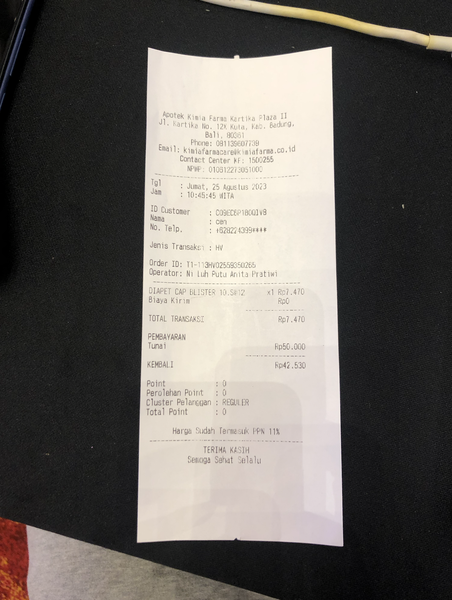

In [2]:
file_name = '/Users/marchelandrianshevchenko/Documents/RPS_Team_Code/Screenshot 2023-08-25 at 20.43.13.png'
img = Image.open(file_name)
img.thumbnail((600,600), Image.ANTIALIAS)
img

In [3]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [4]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [5]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [6]:
image = cv2.imread(file_name)
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

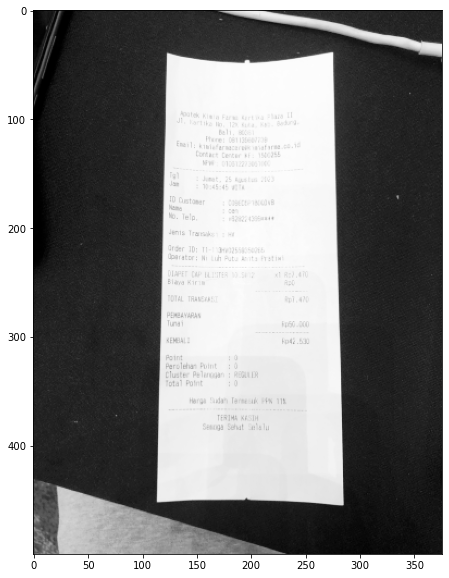

In [7]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

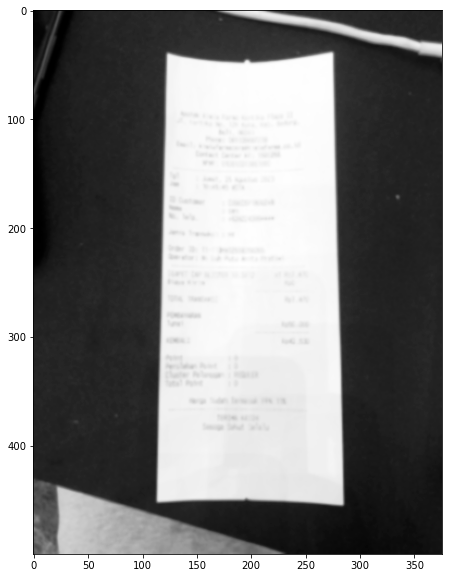

In [8]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

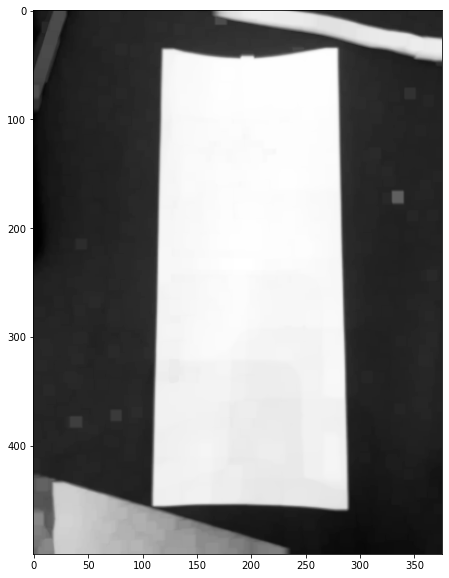

In [9]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

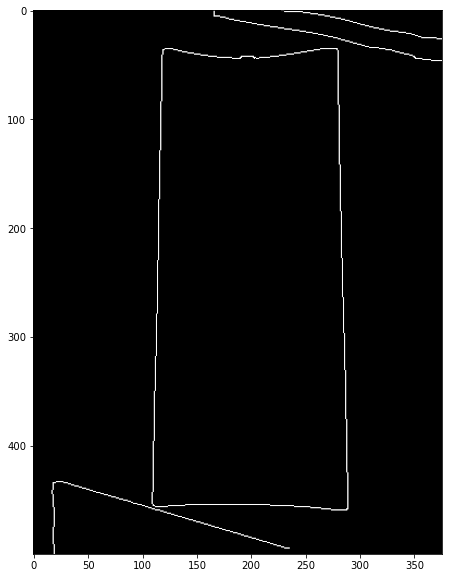

In [10]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

In [11]:
cv2.__version__

'4.5.5'

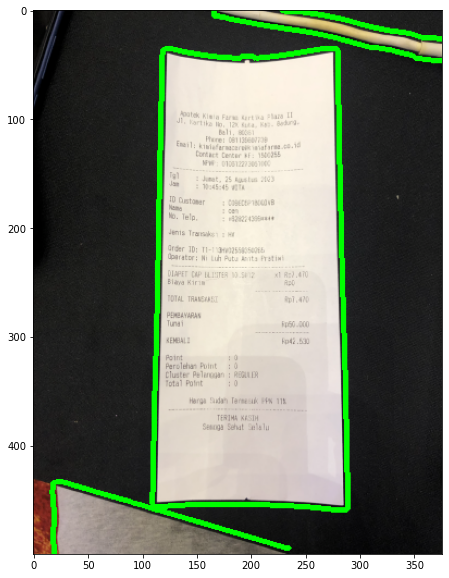

In [12]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

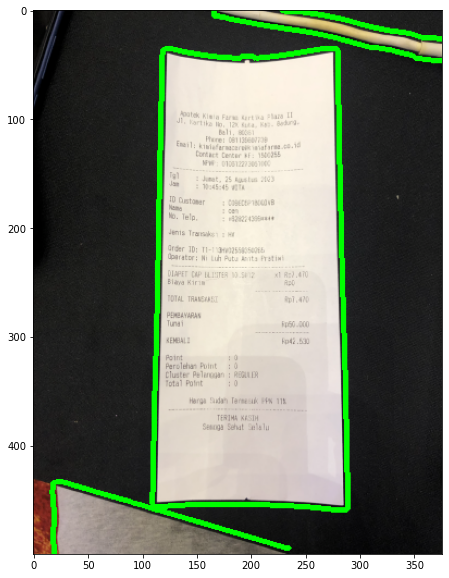

In [13]:
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [14]:
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [15]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [16]:
get_receipt_contour(largest_contours)

array([[[121,  35]],

       [[109, 453]],

       [[288, 459]],

       [[280,  37]]], dtype=int32)

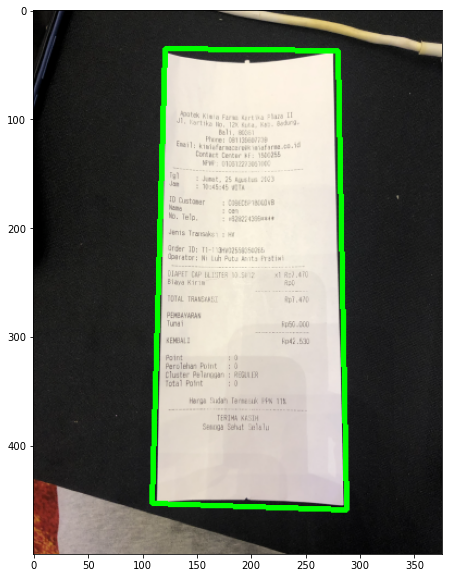

In [17]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0,255,0), 3)
plot_rgb(image_with_receipt_contour)

In [18]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [19]:
def wrap_perspective(img, rect):

    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
  
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

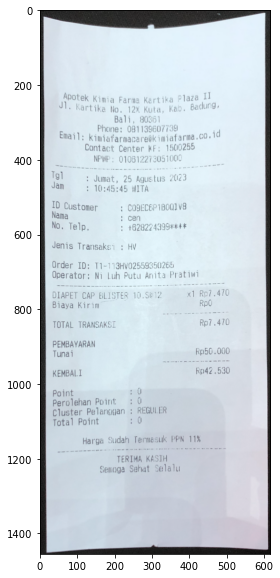

In [20]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [21]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

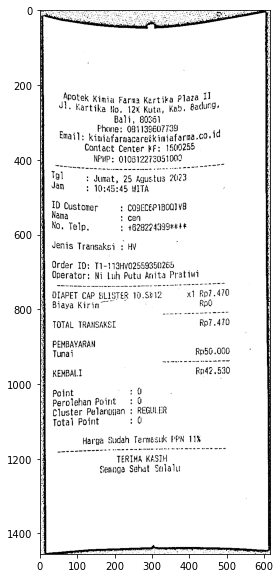

In [22]:
result = bw_scanner(scanned)
plot_gray(result)

In [23]:
output = Image.fromarray(result)
output.save('result.png')

In [24]:
%pip install pytesseract

Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

In [26]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [27]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

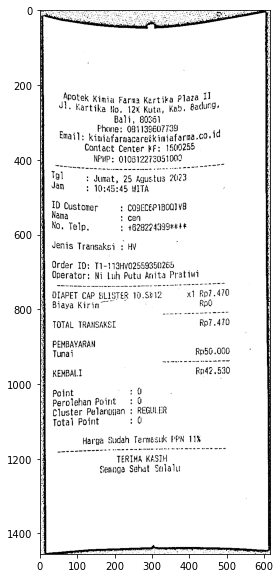

In [28]:
file_name = "/Users/marchelandrianshevchenko/Documents/RPS_Team_Code/result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

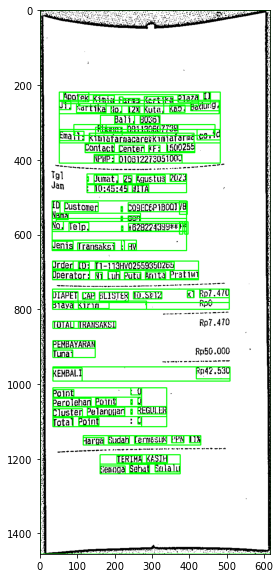

In [29]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [30]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

Apotek Kimia F i Il
: arma Kartika Plaza
JV. Kartik Ho. 12K Kuta, Kad. Batlunde
th Bali, 80861
. Phone: 081139607739 :
Email: kimiafarnacareskimiafarma .co.id
Contact Center KF: 19(0255
NPP: 010812273051000

: Jumat, 25 Agustus 2023
10:45:45 WITA

i Customer : COIECEPIBOQT YB
ama + cen
No, Telp, + 482822401944 + #
denis Transaksi : HY

Order ID: T1-113HV02559950265
Operator: Ni Luh Putu Anita Pratiwi

DIAPET CAP BLISTER 10.Se12 x1 Rp7.470
Biaya Kirin” .

TOTAL TRANSAKSI

PEMBAYARAN
Tunai

KEMBAL.I Rn42.830

Point 70
Perolehan Point 3 0
Cluster Pelanggan : REGULER
Total Point 0

Harga Sudah Termasuk PRN 11%

TERIMA KASTH
Senoga Sehat Salalu


